In [1]:
import pandas as pd

df = pd.read_csv('/home/ron/Documents/AOClassification/data/GRAZPEDWRI-DX_reports.csv')
# limit to front view only
df = df[df['projection']==1]
df['ao_classification'] = df['ao_classification'].fillna('none')
df.reset_index(inplace=True, drop=True)

In [2]:
# Create a DataFrame with the relevant columns
df_exploded = df[['patient_id', 'ao_classification']].copy()

# Split and explode the 'ao_classification' column
df_exploded['ao_classification'] = df_exploded['ao_classification'].str.split(';')
df_exploded = df_exploded.explode('ao_classification').reset_index(drop=True)

# Strip any leading/trailing whitespace from 'ao_classification'
df_exploded['ao_classification'] = df_exploded['ao_classification'].str.strip()

ao_lbl_series = df_exploded['ao_classification']
ao_lbl_series.value_counts()

ao_classification
none              3022
23r-M/3.1         2578
23r-M/2.1         1803
23u-E/7           1607
23u-M/2.1         1161
                  ... 
23r-M/2.1[1,7]       1
23r-E/3.1            1
76.2.A               1
23-M2.1              1
23-M3.1              1
Name: count, Length: 61, dtype: int64

In [3]:
# remove hand and classes that are below a relative threshold
n = 5
min_availability = n * 20
freq = ao_lbl_series.value_counts()
freq = freq[freq>min_availability]

df_exploded = df_exploded[df_exploded['ao_classification'].isin(freq.index)]
df_exploded['ao_classification'].value_counts()

ao_classification
none         3022
23r-M/3.1    2578
23r-M/2.1    1803
23u-E/7      1607
23u-M/2.1    1161
23-M/3.1      827
23r-E/2.1     723
23-M/2.1      706
Name: count, dtype: int64

In [4]:
print(df_exploded['ao_classification'].nunique(), ' unqiue classes remaining')

8  unqiue classes remaining


In [5]:
# create n-folded cross validation splits
from sklearn.model_selection import StratifiedGroupKFold

fold_factory = StratifiedGroupKFold(n_splits=n, shuffle=True, random_state=42)
splits = list(fold_factory.split(df_exploded, groups=df_exploded['patient_id'], y=df_exploded['ao_classification']))

In [6]:
print(len(set(df['patient_id'])))
print(len(set(df_exploded['patient_id'])))

5979
5815


In [7]:
pat_id_mask = df['patient_id'].isin(df_exploded['patient_id'])
ao_class_mask = df['ao_classification'].str.contains('|'.join(df_exploded['ao_classification'].unique()))

df_split = df[pat_id_mask & ao_class_mask].copy()
df_split['fold'] = -1
for i, (_, test_idx) in enumerate(splits):
    fold_pat_ids = df_exploded.iloc[test_idx]['patient_id']
    df_split.loc[df_split['patient_id'].isin(fold_pat_ids), 'fold'] = i
    print(f'Fold {i}: {len(fold_pat_ids)} patients for testing')
assert all(df_split['fold'] != -1)

Fold 0: 2389 patients for testing
Fold 1: 2508 patients for testing
Fold 2: 2512 patients for testing
Fold 3: 2578 patients for testing
Fold 4: 2440 patients for testing


In [8]:
df_split['ao_classification'].value_counts()

ao_classification
none                          3022
23r-M/2.1                     1596
23r-M/3.1; 23u-M/2.1           833
23r-M/3.1; 23u-E/7             764
23r-M/3.1                      747
                              ... 
23u-E/3; 23u-E/7                 1
23r-E/2.1; 23u-M/3.1             1
23r-M/2.1[1,7]                   1
22-D/2.1; 23u-E/7                1
23r-M/2.1; 23u-E/7; 72B(b)       1
Name: count, Length: 71, dtype: int64

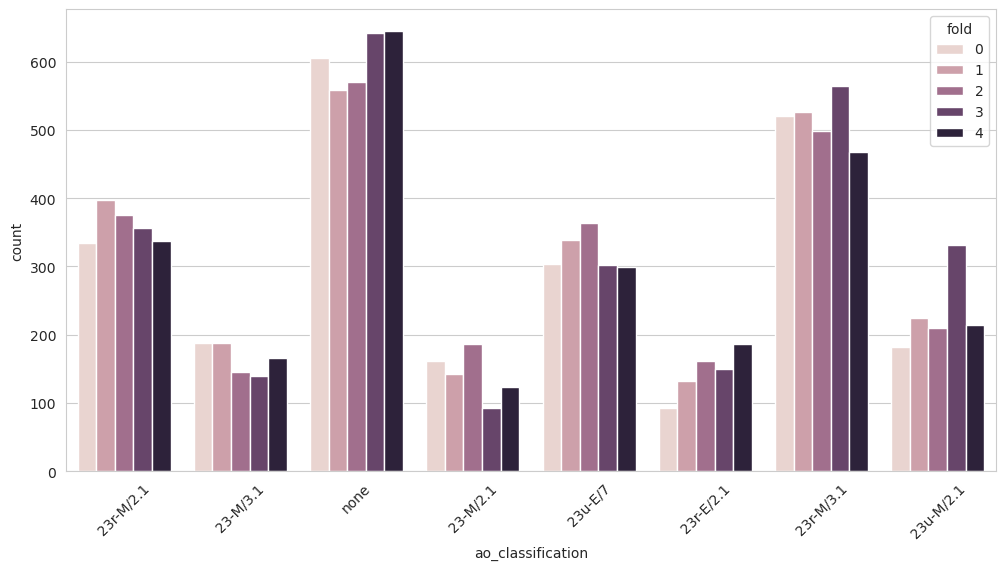

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

df_plot = df_split[['ao_classification', 'fold']].copy()
df_plot['ao_classification'] = df_plot['ao_classification'].str.split(';')
df_plot = df_plot.explode('ao_classification').reset_index(drop=True)
df_plot['ao_classification'] = df_plot['ao_classification'].str.strip()
df_plot = df_plot[df_plot['ao_classification'].isin(df_exploded['ao_classification'])]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_plot, x='ao_classification', hue='fold')
# rotate x-axis labels
plt.xticks(rotation=45);

In [10]:
df_print = df_plot.groupby(['ao_classification', 'fold']).size()
df_print = df_print.reset_index(name='count')
df_print = df_print.pivot(index='ao_classification', columns='fold', values='count')
df_print = df_print.fillna(0)

# add sum column
df_print['sum'] = df_print.sum(axis=1)

df_print

fold,0,1,2,3,4,sum
ao_classification,,,,,,
23-M/2.1,161,142,187,93,123,706
23-M/3.1,188,188,145,140,166,827
23r-E/2.1,93,132,161,150,187,723
23r-M/2.1,335,398,376,356,338,1803
23r-M/3.1,521,527,498,564,468,2578
23u-E/7,303,339,364,302,299,1607
23u-M/2.1,182,224,210,331,214,1161
none,606,558,571,642,645,3022


In [11]:
print('Known classes:', df_exploded['ao_classification'].unique())
df_split.to_csv('/home/ron/Documents/AOClassification/data/dataset_cv_splits.csv', index=False)

Known classes: ['23r-M/2.1' '23-M/3.1' 'none' '23-M/2.1' '23u-E/7' '23r-E/2.1'
 '23r-M/3.1' '23u-M/2.1']
